In [ ]:
!nvidia-smi

Sat Oct 14 14:28:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import imageio.v2 as imageio
from PIL import Image
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Define the paths to the training data
train_data_path = "/content/drive/MyDrive/WCEBleedGen/TrainData"
bleeding_path = train_data_path + "/bleeding"
non_bleeding_path = train_data_path + "/non-bleeding"
# Define the paths to the images and annotations
bleeding_images_path = bleeding_path + "/Images"
bleeding_annotations_path = bleeding_path + "/Annotations"
bleeding_bounding_boxes_path = bleeding_path + "/Bounding boxes/YOLO_TXT"
non_bleeding_images_path = non_bleeding_path + "/images"
non_bleeding_annotations_path = non_bleeding_path + "/annotation"

In [ ]:
# Bleeding
## Images
image_list_bleeding_orig = os.listdir(bleeding_images_path)
image_list_bleeding_orig = list(np.sort(image_list_bleeding_orig))
image_list_bleeding = [bleeding_images_path+'/'+i for i in image_list_bleeding_orig]
## Masks
mask_list_bleeding_orig = os.listdir(bleeding_annotations_path)
mask_list_bleeding_orig = list(np.sort(mask_list_bleeding_orig))
mask_list_bleeding = [bleeding_annotations_path+'/'+i for i in mask_list_bleeding_orig]

# Non Bleeding
## Images
image_list_non_bleeding_orig = os.listdir(non_bleeding_images_path)
image_list_non_bleeding_orig = list(np.sort(image_list_non_bleeding_orig))
image_list_non_bleeding = [non_bleeding_images_path+'/'+i for i in image_list_non_bleeding_orig]
## Masks
mask_list_non_bleeding_orig = os.listdir(non_bleeding_annotations_path)
mask_list_non_bleeding_orig = list(np.sort(mask_list_non_bleeding_orig))
mask_list_non_bleeding = [bleeding_annotations_path+'/'+i for i in mask_list_non_bleeding_orig]


Text(0.5, 1.0, 'Mask')

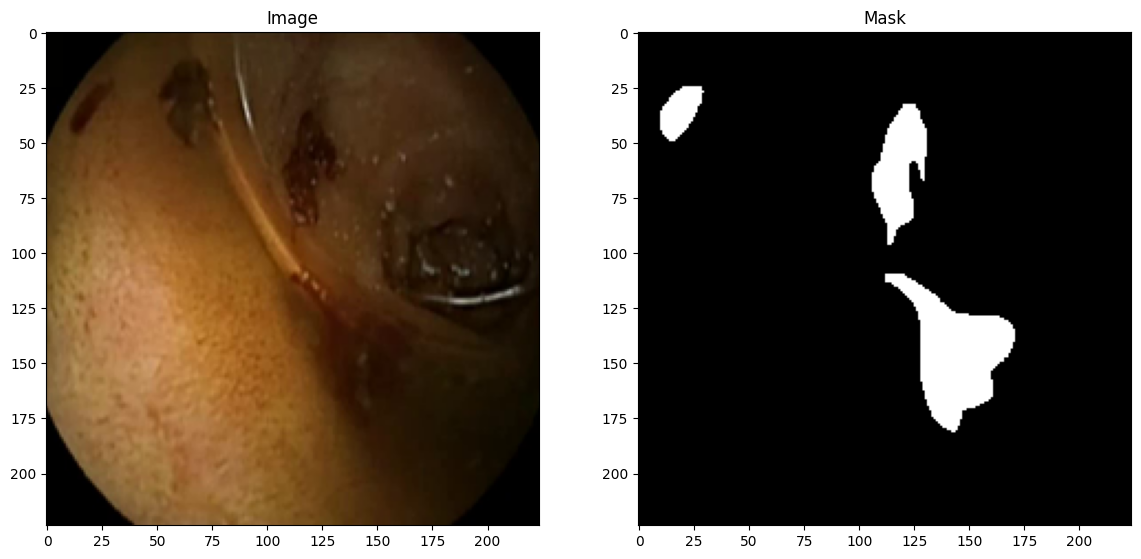

In [ ]:
N = 23
img_t_Bld = imageio.imread(image_list_bleeding[N])
mask_t_Bld = imageio.imread(mask_list_bleeding[N])
# Convert the black and white mask to a binary mask
binary_mask = (mask_t_Bld > 0).astype(np.uint8)  # Assuming the object is represented by non-zero values

#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img_t_Bld)
arr[0].set_title('Image')
arr[1].imshow(binary_mask, cmap='gray')  # Use cmap='gray' to display it in grayscale
arr[1].set_title('Mask')

In [ ]:
random.seed(0)
random_indices = random.sample(range(len(image_list_bleeding)), len(image_list_bleeding))

In [ ]:
split_ratio = 0.8
image_list_bleeding_train = image_list_bleeding[:int(len(image_list_bleeding) * split_ratio)]
image_list_bleeding_val = image_list_bleeding[int(len(image_list_bleeding) * split_ratio): ]
image_list_non_bleeding_train = image_list_non_bleeding[:int(len(image_list_non_bleeding) * split_ratio)]
image_list_non_bleeding_val = image_list_non_bleeding[int(len(image_list_non_bleeding) * split_ratio): ]

In [ ]:
def load_images(image_list):
    images = []
    for img_path in image_list:
        img = cv2.imread(img_path)  # Load the image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB (In certain cases, OpenCV reads the images in the BGR format instead of the standard RGB format)
        #img = cv2.resize(img, (224, 224))  # Resize the image as required
        img = img / 255.0  # Normalize the pixel values
        images.append(img)
    return np.array(images)

In [ ]:
X_train_b = load_images(image_list_bleeding_train)
X_val_b = load_images(image_list_bleeding_val)
X_train_nb = load_images(image_list_non_bleeding_train)
X_val_nb = load_images(image_list_non_bleeding_val)

In [ ]:
print(X_train_b.shape)
print(X_val_b.shape)
print(X_train_nb.shape)
print(X_val_nb.shape)

(1047, 224, 224, 3)
(262, 224, 224, 3)
(1047, 224, 224, 3)
(262, 224, 224, 3)


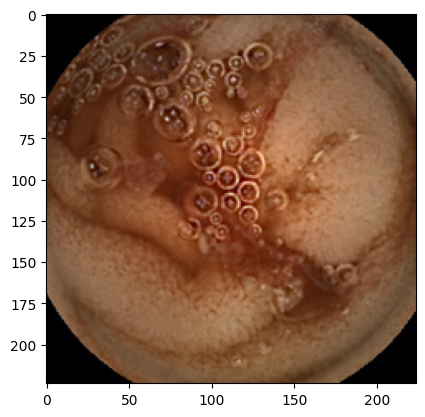

In [ ]:
plt.imshow(np.stack((X_train_b[2, :, :, 0],
                     X_train_b[2, :, :, 1],
                     X_train_b[2, :, :, 2]), axis = -1))

In [ ]:
num_train_samples = X_train_b.shape[0] + X_train_nb.shape[0]
num_val_samples = X_val_b.shape[0] + X_val_nb.shape[0]

# Create labels for the data
y_train = np.concatenate((np.ones(num_train_samples // 2), np.zeros(num_train_samples // 2)))
y_val = np.concatenate((np.ones(num_val_samples // 2), np.zeros(num_val_samples // 2)))

# Shuffle the data and labels (if necessary)
shuffle_indices = np.arange(num_train_samples)
np.random.seed(0)
np.random.shuffle(shuffle_indices)
X_train = np.concatenate((X_train_b, X_train_nb), axis = 0)[shuffle_indices]
y_train = y_train[shuffle_indices]
X_val = np.concatenate((X_val_b, X_val_nb), axis=0)

# Print the shapes of the data and labels
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2094, 224, 224, 3)
y_train shape: (2094,)
X_val shape: (524, 224, 224, 3)
y_val shape: (524,)


# Model

In [ ]:
def create_model1(image_shape):
    """
    Creates a Convolutional Model
    Input Shape:
    Architecture:

    """
    cnn = tf.keras.Sequential()
    # Input Layer
    cnn.add(tf.keras.layers.InputLayer(input_shape = image_shape, name='Input_Layer'))

    # 1st Conv + Maxpooling
    cnn.add(tf.keras.layers.Conv2D(32, (5, 5), padding = 'same', activation = 'relu', name = 'C1'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), name = 'MP1'))
    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1, name = 'DropOut1'))

    # 2nd Conv + Maxpooling
    cnn.add(tf.keras.layers.Conv2D(64, (5, 5), activation = 'relu', name = 'C2'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name = 'MP2'))
    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.2, name = 'DropOut2'))

    # 3rd Conv + Maxpooling
    cnn.add(tf.keras.layers.Conv2D(128, (5, 5), activation = 'relu', name = 'C3'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name = 'MP3'))
    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.3, name = 'DropOut3'))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten(name = 'Dense1'))

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(128, activation = 'relu', name = 'Dense2'))

    # Add the final output layer
    cnn.add(tf.keras.layers.Dense(units = 2, activation = 'sigmoid', name = 'Sigmoid_Output'))

    return cnn

In [ ]:
# Create the model
model1 = create_model1(image_shape = (224, 224, 3))
# Compile the model
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                                    weight_decay = 0.004,
                                                    use_ema = True,
                                                    ema_momentum = 0.9),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = ['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 224, 224, 32)      2432      
                                                                 
 MP1 (MaxPooling2D)          (None, 112, 112, 32)      0         
                                                                 
 DropOut1 (Dropout)          (None, 112, 112, 32)      0         
                                                                 
 C2 (Conv2D)                 (None, 108, 108, 64)      51264     
                                                                 
 MP2 (MaxPooling2D)          (None, 54, 54, 64)        0         
                                                                 
 DropOut2 (Dropout)          (None, 54, 54, 64)        0         
                                                                 
 C3 (Conv2D)                 (None, 50, 50, 128)       2

In [ ]:
def create_model2(image_shape):
  """
  Creates a transfer learning model
  Input Shape:
  Architecture:
  Based on mobilenet_v1

  """
  ## Import the mobilenet_v2 model architecture
  base_model = MobileNetV2(include_top = False,
                           input_shape = (224, 224, 3),
                           alpha=1.0,
                           weights = 'imagenet',
                           pooling = 'avg')
  ## freeze the base model by making it non trainable
  base_model.trainable = False

  # Initiate the model
  model = Sequential()
  model.add(InputLayer(input_shape=image_shape, name='Input_Layer'))

  # Add Base Mobilenet_v2 Model
  model.add(base_model)

  # Add Final Layers
  model.add(Flatten(name = 'Flatten_after_MobileNet_v2'))
  model.add(Dense(256, activation = 'relu', name = 'Dense_Layer1'))
  model.add(Dropout(0.5, name = 'Dropout_Layer1'))
  model.add(Dense(128, activation = 'relu', name = "Dense_Layer2"))
  model.add(Dropout(0.75, name = 'Dropout_Layer2'))

  # Add the final output layer
  model.add(Dense(2, activation = 'softmax', name = 'Softmax_Output'))


  return model

In [ ]:
# Create the model
model2 = create_model2(image_shape = (224, 224, 3))
# Compile the model
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = ['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 Flatten_after_MobileNet_v2  (None, 1280)              0         
  (Flatten)                                                      
                                                                 
 Dense_Layer1 (Dense)        (None, 256)               327936    
                                                                 
 Dropout_Layer1 (Dropout)    (None, 256)               0         
                                                                 
 Dense_Layer2 (Dense)        (None, 128)               32896     
                                                                 
 Dropout_Layer2 (Dropout)    (None, 128)              

## Train

In [ ]:
tick = time.perf_counter()
history = model1.fit(
    X_train, y_train,
    batch_size = 5,
    epochs = 100,
    verbose = 1,
    validation_data = (X_val, y_val),
)

tock = time.perf_counter()
print(f"Time to train model: {(tock-tick)/60:.2f} minutes.")

In [ ]:
tick = time.perf_counter()
history = model2.fit(
    X_train, y_train,
    batch_size = 25,
    epochs = 50,
    verbose = 1,
    validation_data = (X_val, y_val),
)

tock = time.perf_counter()
print(f"Time to train model: {(tock-tick)/60:.2f} minutes.")